# Halo Model comparison with HMCODE and DARKEMU

This notebook make figure 6 of the halo model review `(Asgari,Heymans and Mead 2022)`
We compare matter-matter, matter-galaxy and galaxy-galaxy power spectra. Halo model predictions are calculated with and without the non-linear halo-halo power spectrum correction. The results are then compared with both HMCode ([Mead et. al. 2015](https://arxiv.org/abs/1505.07833), [2021](https://arxiv.org/abs/2009.01858)), an augmented halo model code which has been calibrated against simulations and DarkEmu which is an emulator for the Dark Quest simulations ([Nishimichi et al. 2019](https://arxiv.org/abs/1811.09504) and 
[Miyatake et al. 2020](https://arxiv.org/abs/2101.00113)). 

In [1]:
# Standard import
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import logging

# Third-party imports
import camb
# import pyhmcode as hmcode 
from dark_emulator import darkemu, model_hod

# Imports from the halo model repo
import halomodel
import DarkQuest
import utility_functions as utility
import constants as const

# Turn off matplotlib debug statements (caused by running Dark Quest)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

### Cosmlogical parameters
Lets set the cosmological parameters. The first set are the parameters that CAMB takes as input, but we also calculate a few derived parameters. If you want to set sigma_8 instead of As then set `sigma_8_set = True`

In [24]:
# Set cosmological parameters
Omega_c = 0.2537
Omega_b = 0.045
Omega_k = 0.0
h = 0.7
As = 2.1e-9
ns = 0.97
w = -1.0
wa = 0.0
m_nu = 0.06 # in eV


# Set cosmological parameters DES-Y3+
Omega_c = 0.23589517691109066
Omega_b = 0.04610
Omega_k = 0.0
h = 0.697
As = 2.168734429343111e-09
ns = 0.9646
w = -1.0
wa = 0.0
m_nu = 0.06 # in eV


# Set cosmological parameters mead and verse
# Omega_c = 0.2231
# Omega_b = 0.0469
# Omega_k = 0.0
# h = 0.7
# As = 2.168734429343111e-09
# ns = 0.95
# w = -1.0
# wa = 0.0
# m_nu = 0.00 # in eV

# derived parameters
wb   = Omega_b*h**2
wc   = Omega_c*h**2
Omega_nu_in =  m_nu/const.nuconst/h**2 # Note: this is very slightly different from what CAMB calculates
lnAs = np.log(1e10*As)
Omega_m_in = Omega_c + Omega_b + Omega_nu_in # Note: this is very slightly different from what CAMB calculates

# You can choose to set sigma_8, in that case we scale the power spectrum
sigma_8_set = False # if true uses the following value
sigma_8_in  = 0.7


### HOD and other parameters
Now lets set the parameters for the three methods that we want to compare. The critical linear over density, $\delta_{rm c}$= dc. The halo overdensity with respect to the background overdensity $\Delta_{\rm halo}$=Dv. Note that v in Dv stands for virial, but $\Delta_{\rm halo}$ is not always defined as the virial overdensity. 

In [25]:
# Wavenumbers
kmin = 1e-3
kmax = 20.

# redshift
zmin = 0. 
zmax = 2.
nz = 11
zs = np.linspace(zmin, zmax, nz)
z = 2.0 #This is the redshift where we do the comparison. 

# HOD parameters
Mmin_HOD = 10**13
sigma_HOD = 0.5
M0_HOD = Mmin_HOD
M1_HOD = 10**14
alpha_HOD = 1.0

# HMcode version
# HMcode_version = hmcode.HMcode2020


# Halo model parameters
Mmin = 1e3
Mmax = 1e17
nM = 120
Ms = utility.logspace(Mmin, Mmax, nM)
halomodel_version = 'Tinker et al. (2010)'
dc = 1.686 
Dv = 200.
Mdef = 'M200'
central_condition = True
consider_variance = True
add_shotnoise = False
discrete_gal = True

### CAMB
Lets run CAMB to the get the linear power spectrum. We can also get the nonlinear power spectra from CAMB and compare results with that. Currently we have set the nonlinear power to `mead2020` which is the 2020 version of HMcode without baryon feedback. Check [CAMB documentation](https://camb.readthedocs.io/en/latest/nonlinear.html?highlight=nonlinear#camb.nonlinear.NonLinearModel) for other options.

In [26]:
# Use CAMB to get the linear power spectrum and sigma(R)

# Sets cosmological parameters in camb to calculate the linear power spectrum
pars = camb.CAMBparams()

# This function sets standard and helium set using BBN consistency
pars.set_cosmology(ombh2=wb, omch2=wc, H0=100.*h, mnu=m_nu, omk=Omega_k)
pars.set_dark_energy(w=w, wa=wa, dark_energy_model='ppf') 
pars.InitPower.set_params(As=As, ns=ns, r=0)
pars.set_matter_power(redshifts=zs, kmax=kmax) # Setup the linear matter power spectrum

camb.set_params(halofit_version='mead2020')

# extract parameters from CAMB
Omega_m  = pars.omegam 
Omega_nu = pars.omeganu
Omega_L  = 1. + Omega_k - Omega_m
camb_results = camb.get_results(pars)
# get_sigma8 produces sigma_8(z)
sigma_8 = (camb_results.get_sigma8()[-1]).item()

if sigma_8_set:
    scaling = (sigma_8_in/sigma_8)**2
    As *= scaling
    lnAs = np.log(1e10*As)
    pars.InitPower.set_params(As=As, ns=ns, r=0)

Pk_lin = camb.get_matter_power_interpolator(pars, 
                                            nonlinear = False, 
                                            hubble_units = True, 
                                            k_hunit = True, 
                                            kmax = kmax,
                                            var1 = camb.model.Transfer_tot,
                                            var2 = camb.model.Transfer_tot, 
                                            zmax = zmax,
                                           )
camb_results = camb.get_results(pars)
sigma_8 = (camb_results.get_sigma8()[-1]).item()

Pk_lin = Pk_lin.P # Single out the linear P(k) interpolator


# You can use this to find the non-linear powers spectra using CAMB. 
# In this notebook we use pyhmcode to get the non-linear power. 
# Create a power spectrum interpolation object from CAMB for the nonlinear power spectrum
Pk_nonlin = camb.get_matter_power_interpolator(pars, 
                                            nonlinear = True, 
                                            hubble_units = True, 
                                            k_hunit = True, 
                                            kmax = kmax,
                                            var1 = camb.model.Transfer_tot,
                                            var2 = camb.model.Transfer_tot, 
                                            zmax = zmax,
                                           )
Pk_nonlin = Pk_nonlin.P

# Get CAMB P(k)
camb_results = camb.get_results(pars)
ks, zs, Pk = camb_results.get_linear_matter_power_spectrum(nonlinear=False)
#get an array for linear power from camb for the input resdhift, z. We are using the above line just to get ks
Pk_lin_camb = Pk_lin(z, ks) 
Pk_HMcode_mm = Pk_nonlin(z,ks)

Note: redshifts have been re-sorted (earliest first)


### PyHMcode
Now we setup pyhmcode and produce the non-linear matter power spectrum

In [27]:
ks.shape
# Setup HMcode internal cosmology
# c = hmcode.Cosmology()
# c.om_m = Omega_m
# c.om_b = Omega_b
# c.om_v = Omega_L
# c.h = h
# c.ns = ns
# c.sig8 = sigma_8
# c.m_nu = m_nu
# c.w = w
# c.wa = wa
# Pk_lin_HMcode = Pk_lin(zs, ks)
# c.set_linear_power_spectrum(ks, zs, Pk_lin_HMcode)

# # Setup HMcode
# hmod = hmcode.Halomodel(HMcode_version, verbose=False)
    
# # HMcode power spectrum calculation
# Pk_HMcode = hmcode.calculate_nonlinear_power_spectrum(c, hmod, verbose=False)
# Pk_HMcode_interp = interp2d(np.log(ks), zs, np.log(Pk_HMcode), kind='cubic')
# Pk_HMcode_mm = np.exp(Pk_HMcode_interp(np.log(ks), z))

(215,)

### Dark Emulator
Next lets setup the Dark Emulator

In [28]:
# Dark Quest

# Init HOD and cosmology
DQ_cosmo = DarkQuest.cosmology(wb=wb, wc=wc, Om_w=Omega_L, lnAs=lnAs, ns=ns, w=w)
emu = DarkQuest.init_emulator(DQ_cosmo)
hod = model_hod.darkemu_x_hod({"fft_num":8})
hod.set_cosmology(DQ_cosmo.cosmology_array())

# Set HOD
gparam = {"logMmin": np.log10(Mmin_HOD), 
          "sigma_sq": sigma_HOD**2, 
          "logM1": np.log10(M1_HOD), 
          "alpha": alpha_HOD, 
          "kappa": M0_HOD/Mmin_HOD,
          "poff": 0.0, # Fraction of off-centered galaxies.
          "Roff": 0.1, # Typical off-centered scale with respect to R200m.
          "sat_dist_type": "emulator", # Satellite distribution (emulator or NFW w/ DK2015 c-M relation).
          "alpha_inc": 0.0, # Incompleteness?
          "logM_inc": 13.57 # Incompleteness: For details, see More et al. (2015)
         } 
hod.set_galaxy(gparam)

# Get P(k) from Dark Quest
Pk_dq_mg = DarkQuest.get_p_gm(hod, ks, z)
Pk_dq_gg = DarkQuest.get_p_gg(hod, ks, z)
# We can get the matter power spectrum from the DarkEmu, but we will not use that in this demo
Pk_dq_mm = DarkQuest.get_Pk_mm(emu,ks, z,nonlinear=True)

Initialize Dark Quest
initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator

Dark Quest primary parameters
omega_b: 0.0224
omega_c: 0.1146
Omega_w: 0.7167
As [1e9]: 2.1687
ns: 0.9646
w: -1.0000

Dark Quest derived parameters
Omega_m: 0.2833
Omega_b: 0.0461
omega_m: 0.1376
h: 0.6970
Omega_c: 0.2359
Omega_nu: 0.0013
m_nu [eV]: 0.0596

Derived sigma_8: 0.8046468974371539

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


ValueError: x must be strictly increasing when `grid` is True

### $\beta_{\rm nl}$

Now we calculate $\beta_{\rm nl}$ which is used to create the nonlinear halo-halo power spectra. With fill_value=None we extrapolate the beta_NL values via the nearest-neighbor extrapolation

In [ ]:
# Beta-NL 
# Dark Quest parameters
Mmin_Bnl = 10**12.2
Mmax_Bnl = 10**15.1
nM_Bnl = 11
include_Bnl = True

# ks_bnl=utility.logspace(kmin, kmax, 100)

if include_Bnl:
    Ms_Bnl = utility.logspace(Mmin_Bnl, Mmax_Bnl, nM_Bnl)
    beta_NL_small = DarkQuest.get_beta_NL(emu, Ms_Bnl, ks, z,force_to_zero=4, mass_variable='Mass')
else:
    beta_NL = None


# interpolation='2D'
# if include_Bnl:
#     if interpolation=='2D':
#         beta_NL = halomodel.interpolate_beta_NL(ks, Ms, Ms_Bnl, beta_NL_small, fill_value=None)
#     else:
#         beta_NL = halomodel.RegularGridInterp_beta_NL(ks, Ms_Bnl, beta_NL_small,method='linear')

In [ ]:
# beta_NL = halomodel.interpolate_beta_NL(ks, Ms, Ms_Bnl, beta_NL_small, fill_value=None)
def RegularGridInterp_beta_NL(Ms_in, ks_in,beta_NL_in,Ms_out,ks_out ,method='linear'):
    from scipy.interpolate import RegularGridInterpolator
    bnl_interp = RegularGridInterpolator([Ms_in, Ms_in, np.log(ks_in)], beta_NL_in,
        method=method, fill_value=None, bounds_error=False)
    bnl_out = np.zeros((Ms_out.size, Ms_out.size, ks_out.size))
    indices = np.vstack(np.meshgrid(np.arange(Ms_out.size),np.arange(Ms_out.size),np.arange(ks_out.size), 
                                    copy = False)).reshape(3,-1).T
    values = np.vstack(np.meshgrid(Ms_out, Ms_out, np.log(ks_out), 
                                   copy = False)).reshape(3,-1).T
    bnl_out[indices[:,0], indices[:,1], indices[:,2]] = bnl_interp(values)
    return bnl_out  

def RegularGridInterp_beta_NL_log(Ms_in, ks_in,beta_NL_in,Ms_out,ks_out ,method='linear'):
    from scipy.interpolate import RegularGridInterpolator
    bnl_interp = RegularGridInterpolator([np.log10(Ms_in), np.log10(Ms_in), np.log(ks_in)], beta_NL_in,
        method=method, fill_value=None, bounds_error=False)
    bnl_out = np.zeros((Ms_out.size, Ms_out.size, ks_out.size))
    indices = np.vstack(np.meshgrid(np.arange(Ms_out.size),np.arange(Ms_out.size),np.arange(ks_out.size), 
                                    copy = False)).reshape(3,-1).T
    values = np.vstack(np.meshgrid(np.log10(Ms_out), np.log10(Ms_out), np.log(ks_out), 
                                   copy = False)).reshape(3,-1).T
    bnl_out[indices[:,0], indices[:,1], indices[:,2]] = bnl_interp(values)
    return bnl_out  


# Supported methods are “linear”, “nearest”, “slinear”, “cubic”, and “quintic”

In [ ]:
beta_NL_in = beta_NL_small.copy()
knl=6
index_knl,knl_closest=utility.findClosestIndex(knl,ks)
for iM1 in range(len(Ms_Bnl)):
    for iM2 in range(len(Ms_Bnl)):
#         print(iM1,iM2)
         beta_NL_in[iM1,iM2,:]= beta_NL_small[iM1, iM2, :]*(1.-np.exp(-(knl_closest/ks)**2.))

In [29]:
bnl_linear = RegularGridInterp_beta_NL(Ms_Bnl, ks,beta_NL_in,Ms,ks,method='linear')
bnl_linear_log = RegularGridInterp_beta_NL_log(Ms_Bnl, ks,beta_NL_in,Ms,ks,method='linear')

ValueError: There are 4 points and 11 values in dimension 0

In [30]:
# function= (1.-np.exp(-(knl_closest/ks)**5.))
# plt.plot(ks,function)

14.76470588235294 14.76470588235294


120

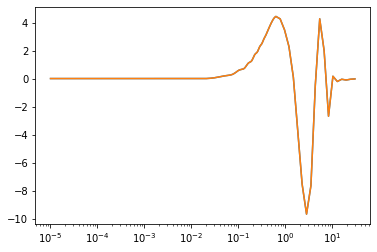

In [31]:
iM1=100
iM2=100
M1=Ms[iM1]
M2=Ms[iM2]
plt.plot(ks,bnl_linear[iM1,iM2,:])
plt.plot(ks,bnl_linear_log[iM1,iM2,:])
plt.xscale('log')
print(np.log10(M1),np.log10(M2))
nM
# plt.semilogx(ks,Pk_dq_mm/Pk_HMcode_mm)
# plt.semilogx(ks,np.ones(ks.size))
# plt.ylim(0.95,1.05)
# plt.xlim(1e-3,1e1)


In [13]:
# bnl_slinear=RegularGridInterp_beta_NL(Ms_Bnl, ks,beta_NL_in,Ms,ks,method='slinear')

In [14]:
# bnl_cubic  =RegularGridInterp_beta_NL(Ms_Bnl, ks,beta_NL_in,Ms,ks,method='cubic')

In [13]:
beta_NL=bnl_linear.copy()

# from the cosmosis module
# from scipy.interpolate import RegularGridInterpolator
# def create_bnl_interpolation_function(ks, Ms_Bnl, beta_NL_small,method='linear'):
#     beta_nl_interp = RegularGridInterpolator([Ms_Bnl, Ms_Bnl, ks], beta_NL_small,method=method, fill_value=None, bounds_error=False)
#     return beta_nl_interp   

# ks_bnl=ks
# # Supported methods are “linear”, “nearest”, “slinear”, “cubic”, and “quintic”
# bnl_interp = create_bnl_interpolation_function(ks_bnl, Ms_Bnl, beta_NL_small,method='slinear')
# bnl_slinear = np.zeros((Ms.size, Ms.size, ks.size))
# indices = np.vstack(np.meshgrid(np.arange(Ms.size),np.arange(Ms.size),np.arange(ks.size), copy = False)).reshape(3,-1).T
# values = np.vstack(np.meshgrid(Ms, Ms, ks, copy = False)).reshape(3,-1).T
# bnl_slinear[indices[:,0], indices[:,1], indices[:,2]] = bnl_interp(values)

In [55]:
# bnl_interp = create_bnl_interpolation_function(ks_bnl, Ms_Bnl, beta_NL_small,method='cubic')
# bnl_cubic = np.zeros((Ms.size, Ms.size, ks.size))
# indices = np.vstack(np.meshgrid(np.arange(Ms.size),np.arange(Ms.size),np.arange(ks.size), copy = False)).reshape(3,-1).T
# values = np.vstack(np.meshgrid(Ms, Ms, ks, copy = False)).reshape(3,-1).T
# bnl_cubic[indices[:,0], indices[:,1], indices[:,2]] = bnl_interp(values)

# bnl_interp = create_bnl_interpolation_function(ks_bnl, Ms_Bnl, beta_NL_small,method='quintic')
# bnl_quintic = np.zeros((Ms.size, Ms.size, ks.size))
# indices = np.vstack(np.meshgrid(np.arange(Ms.size),np.arange(Ms.size),np.arange(ks.size), copy = False)).reshape(3,-1).T
# values = np.vstack(np.meshgrid(Ms, Ms, ks, copy = False)).reshape(3,-1).T
# bnl_quintic[indices[:,0], indices[:,1], indices[:,2]] = bnl_interp(values)

NameError: name 'bnl' is not defined

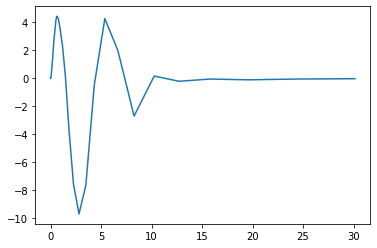

In [14]:
iM1=100
iM2=100
M1=Ms[iM1]
M2=Ms[iM2]
plt.plot(ks,beta_NL[iM1,iM2,:])
plt.plot(ks,bnl[iM1,iM2,:])
plt.xscale('log')
print(np.log10(M1),np.log10(M2))
beta_NL[0,0,0]

In [32]:
# Dark Quest parameters
Mmin_Bnl = 10**12.2
Mmax_Bnl = 10**15.1
nM_Bnl = 5
Ms_Bnl = utility.logspace(Mmin_Bnl, Mmax_Bnl, nM_Bnl)

Ms_Bnl = np.array([10**12.2,10**13.2,10**13.8,10**14.3])

# # Halo model parameters
Mmin = 1e7; 
Mmax = 1e17
nM = 129
Ms = utility.logspace(Mmin, Mmax, nM)
kmin = 5e-3
kmax = 1e0
nk = 100
ks_Bnl = utility.logspace(kmin, kmax, nk)
beta_NL_small = DarkQuest.get_beta_NL(emu, Ms_Bnl, ks_Bnl, z,force_to_zero=0, mass_variable='Mass')
# beta_NL_small_additive = DarkQuest.get_beta_NL(emu, Ms_Bnl, ks_Bnl, z,force_to_zero=1, mass_variable='Mass')
# beta_NL_small_multiplicative = DarkQuest.get_beta_NL(emu, Ms_Bnl, ks_Bnl, z,force_to_zero=2, mass_variable='Mass')
# beta_NL_small_3 = DarkQuest.get_beta_NL(emu, Ms_Bnl, ks_Bnl, z,force_to_zero=3, mass_variable='Mass')
# beta_NL_small_4 = DarkQuest.get_beta_NL(emu, Ms_Bnl, ks_Bnl, z,force_to_zero=4, mass_variable='Mass')
# beta_NL_small_5 = DarkQuest.get_beta_NL(emu, Ms_Bnl, ks_Bnl, z,force_to_zero=5, mass_variable='Mass')
beta_NL_small_6 = DarkQuest.get_beta_NL(emu, Ms_Bnl, ks_Bnl, z,force_to_zero=6, mass_variable='Mass')


beta_NL = halomodel.interpolate_beta_NL(ks_Bnl, Ms, Ms_Bnl, beta_NL_small, fill_value=None)

/Users/masgari/opt/anaconda3/lib/python3.8/site-packages/dark_emulator/darkemu/hmf.py:100: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  dens = integrate.quad(lambda t: np.exp(


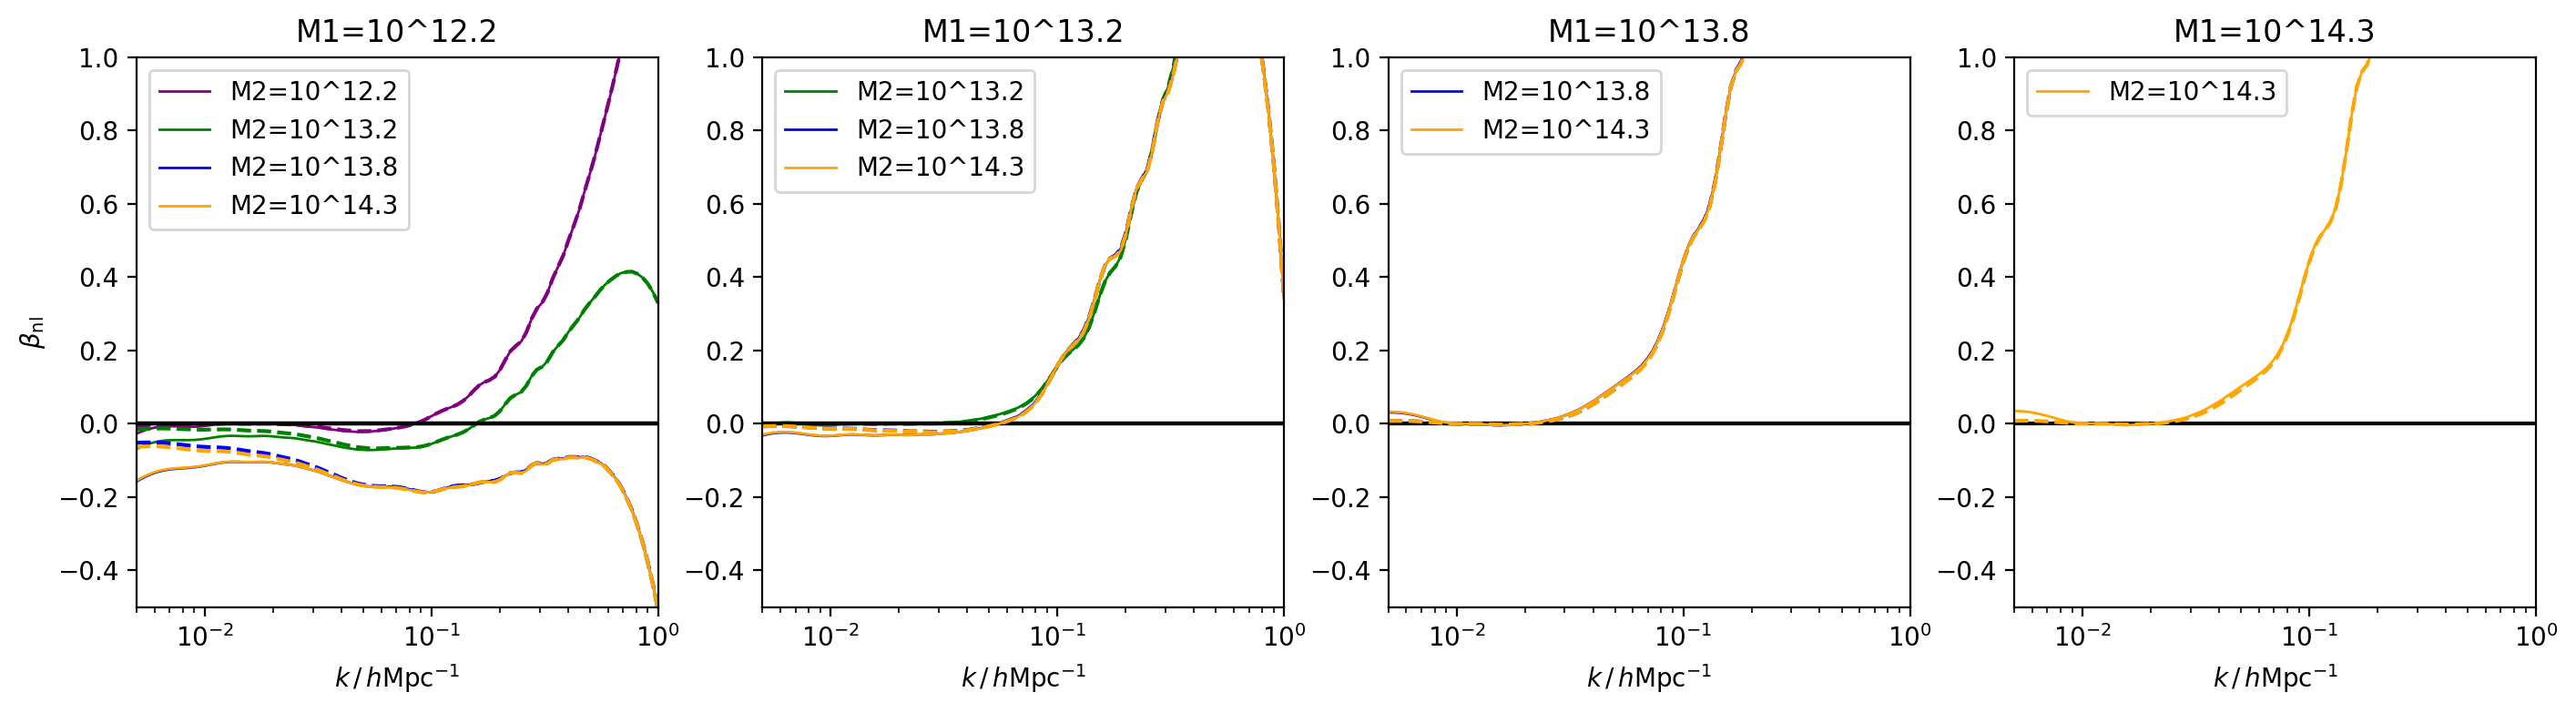

In [33]:
cols = ['purple','g','b','orange']
plt.subplots(1, len(Ms_Bnl), figsize=(17, 4), dpi=200)
klin=0.02

for iM1 in range(len(Ms_Bnl)):
    plt.subplot(1, len(Ms_Bnl), iM1+1)
    plt.title('M1=10^'+str(np.log10(Ms_Bnl[iM1])))
    M1=Ms_Bnl[iM1]
    for iM2 in range(iM1,len(Ms_Bnl)):
        M2=Ms_Bnl[iM2]
        if (iM1 == iM2) or (np.log10(M2/M1)<1):
            truncate_bnl= (1.-np.exp(-(ks_Bnl/klin)))
        else:
            truncate_bnl= (1.-np.exp(-(ks_Bnl/klin)*np.log10(M2/M1)))
        plt.plot(ks_Bnl,np.zeros(len(ks_Bnl)),color='k',ls='-')
        plt.plot(ks_Bnl,beta_NL_small[iM1,iM2,:],lw=1,color=cols[iM2],label='M2=10^'+str(np.log10(M2)))
        plt.plot(ks_Bnl,beta_NL_small[iM1,iM2,:]*truncate_bnl,color=cols[iM2],ls='--')
        plt.xscale('log')
        plt.xlim(kmin,kmax)
        plt.ylim(-0.5,1)
        plt.xlabel(r'$k\,/\,h\mathrm{Mpc}^{-1}$')
        plt.legend()
        
        if iM1==0:
            plt.ylabel(r'$\beta_{\rm nl}$')             
            

plt.savefig('Bnl.png',bbox_inches='tight')
plt.show()

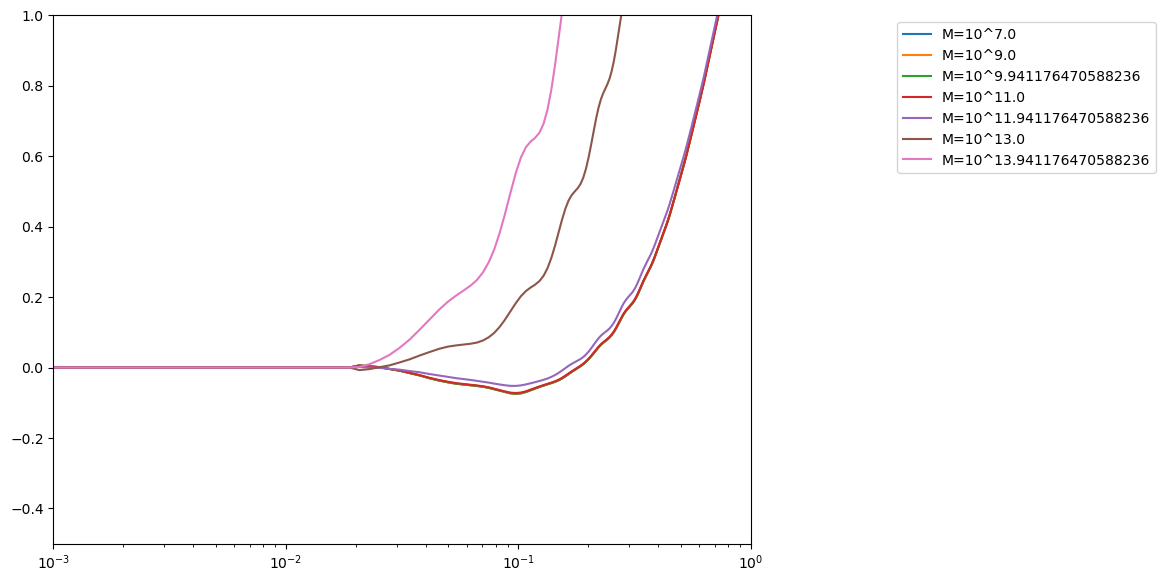

In [15]:

cols = ['r','b','k','orange']
plt.subplots(1, 1, figsize=(9, 7), dpi=100)
plot_Ms = [10**7,10**9,10**10,10**11,10**12,10**13,10**14]
for iM in range(len(plot_Ms)):
    index_Ms, Ms_nearest = utility.findClosestIndex(plot_Ms[iM],Ms)
    plt.plot(ks,beta_NL[index_Ms,index_Ms,:],label='M=10^'+str(np.log10(Ms_nearest)))
plt.xscale('log')
plt.xlim(1e-3,1)
plt.ylim(-0.5,1)
# plt.xlabel(r'$k\,/\,h\mathrm{Mpc}^{-1}$')
# plt.ylabel('Bnl')
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.show()

### $\sigma(R)$
Get $\sigma(R)$ from CAMB. This is needed in the next step. 

In [12]:
# Get CAMB sigma(R)
# NOTE: Tricky with array ordering and needing to flip dimension on z
Rs = utility.Radius_M(Ms, Omega_m) # Lagrangian radii corresponding to halo masses
sigmaRs_camb = camb_results.get_sigmaR(Rs, hubble_units=True)
logsigmaR_interp = interp2d(np.log(Rs), np.flip(zs), np.log(sigmaRs_camb), kind='cubic')
sigmaRs = np.exp(logsigmaR_interp(np.log(Rs), z))

# Get sigma(R) using quad integration. Ignore the warning it is more accurate than CAMB, but slower
# sigmaRs_quad = utility.get_sigmaR(Rs,Pk_lin=lambda k: Pk_lin(0, k),integration_type='quad')
# sigmaRs = sigmaRs_quad
ks.max()

30.12912368774414

### Halo Model 
Now we initialise the halo model code and create power spectra

In [13]:
# Halo model

# Initialise halo model
hmod = halomodel.halomod(z, Omega_m, hm=halomodel_version, dc=dc, Dv=Dv, verbose=True)

# HOD
N_cen, N_sat = halomodel.HOD_Zheng(Ms, Mmin=Mmin_HOD, 
                                       sigma=sigma_HOD, 
                                       M0=M0_HOD, 
                                       M1=M1_HOD, 
                                       alpha=alpha_HOD)
if consider_variance:
    var_cen, var_sat, _ = halomodel.HOD_variance(N_cen, N_sat, central_condition)
else:
    var_cen = None; var_sat = None

# Halo window functions
nk = len(ks)
Uk = np.zeros((nM, nk))
Uk_cen = np.ones((nM, nk))
for iM, M in enumerate(Ms):
    c = halomodel.conc_Duffy(M, z, halo_definition=Mdef)
    rv = halomodel.virial_radius(M, hmod.Dv, Omega_m)
    Uk[iM, :] = halomodel.win_NFW(ks, rv, c)

# Densities
rhom = utility.comoving_matter_density(Omega_m)
rhog = halomodel.mean_hm(hmod, Ms, N_cen+N_sat, sigmas=sigmaRs)

# Halo profiles
# Note that you need mass=True for matter profiles, and discrete=True and some variance for galaxy profiles
profile_mat = halomodel.haloprof(ks, Ms, Ms, Uk, rhom, mass=True)
profile_cen = halomodel.haloprof(ks, Ms, N_cen, Uk_cen, rhog, var=var_cen, discrete=discrete_gal)
profile_sat = halomodel.haloprof(ks, Ms, N_sat, Uk, rhog, var=var_sat, discrete=discrete_gal)
profiles    = [profile_mat, profile_cen, profile_sat]

# Calculate (and organize) the halo-model power spectrum
for beta in [None, beta_NL]:
    Pk_2h, Pk_1h, Pk_hm = halomodel.Pk_hm(hmod, Ms, ks, profiles, 
                                          lambda k: Pk_lin(z, k), 
                                          sigmas = sigmaRs,
                                          beta   = beta,
                                          shot   = add_shotnoise,
                                          trunc_1halo = True,
                                          verbose= True)
    if beta is None:
        Pk_2h_mm = Pk_2h[0, 0, :]
        Pk_1h_mm = Pk_1h[0, 0, :]
        Pk_hm_mm = Pk_hm[0, 0, :]
        Pk_2h_gg = Pk_2h[1, 1, :]+2.*Pk_2h[1, 2, :]+Pk_2h[2, 2, :]
        Pk_1h_gg = Pk_1h[1, 1, :]+2.*Pk_1h[1, 2, :]+Pk_1h[2, 2, :]
        Pk_hm_gg = Pk_hm[1, 1, :]+2.*Pk_hm[1, 2, :]+Pk_hm[2, 2, :]
        Pk_2h_mg = Pk_2h[0, 1, :]+Pk_2h[0, 2, :]
        Pk_1h_mg = Pk_1h[0, 1, :]+Pk_1h[0, 2, :]
        Pk_hm_mg = Pk_hm[0, 1, :]+Pk_hm[0, 2, :]
    else:
        Pk_2h_bnl_mm = Pk_2h[0, 0, :]
        Pk_1h_bnl_mm = Pk_1h[0, 0, :]
        Pk_hm_bnl_mm = Pk_hm[0, 0, :]
        Pk_2h_bnl_gg = Pk_2h[1, 1, :]+2.*Pk_2h[1, 2, :]+Pk_2h[2, 2, :]
        Pk_1h_bnl_gg = Pk_1h[1, 1, :]+2.*Pk_1h[1, 2, :]+Pk_1h[2, 2, :]
        Pk_hm_bnl_gg = Pk_hm[1, 1, :]+2.*Pk_hm[1, 2, :]+Pk_hm[2, 2, :]
        Pk_2h_bnl_mg = Pk_2h[0, 1, :]+Pk_2h[0, 2, :]
        Pk_1h_bnl_mg = Pk_1h[0, 1, :]+Pk_1h[0, 2, :]
        Pk_hm_bnl_mg = Pk_hm[0, 1, :]+Pk_hm[0, 2, :]
# Note beta_nl has no impact on the 1 halo term. So all Pk_1h_bnl_* = Pk_1h_*

Initialising halo model
scale factor: 0.999
redshift: 0.001
Omega_m(z=0): 0.282
delta_c: 1.6860
Delta_v: 200.0
Tinker et al. (2010) mass function
alpha: 0.368; beta: 0.589; gamma: 0.864; phi: -0.729; eta: -0.243
A: 1.000; a: 0.132
B: 0.183; b: 1.500
C: 0.265; c: 2.400

Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.18503020641775747
Halomodel calculation time [s]: 0.1951148509979248 

Missing halo-bias-mass from the low-mass end of the two-halo integrand: 0.18503020641775747
Halomodel calculation time [s]: 71.20615768432617 



In [62]:
# import scipy.integrate as integrate

# def Pk_hm(hmod, Ms, ks, profs, Pk_lin, beta=None, sigmas=None, sigma=None,
#           shot=False, discrete=True, trunc_1halo=False, k_star=0.1 ,verbose=False, do_I11=True):
#     nf = len(profs) # Number of profiles
#     # Create arrays of R (Lagrangian radius) and nu values that correspond to the halo mass
#     nus = _get_nus(Ms, hmod.dc, hmod.Om_m, sigmas, sigma, Pk_lin)
#     # Calculate the missing halo-bias from the low-mass part of the integral
#     A = 1.-integrate.quad(lambda nu: hmod.halo_mass_function(nu)*hmod.linear_halo_bias(nu), nus[0], np.inf)[0] # from nu_min to infinity
#     if verbose: print('Missing halo-bias-mass from the low-mass end of the two-halo integrand:', A)
#     if A < 0.:  warnings.warn('Warning: Mass function/bias correction is negative!', RuntimeWarning)

#     # Fill arrays for results
#     nk = len(ks)
#     Pk_2h_array = np.zeros((nf, nf, nk))
#     # Loop over halo profiles
#     for u, pu in enumerate(profs): 
#         for v, pv in enumerate(profs):
#             if u <= v:
#                 for ik, k in enumerate(ks): # Loop over wavenumbers
#                     if beta is None: # Two-halo term, treat non-linear halo bias carefully
#                         Pk_2h_array[u, v, ik] = P_2h(hmod, Pk_lin, k, Ms, nus, 
#                                                       pu.Wk[:, ik], pv.Wk[:, ik], # TODO: Replace with Uk/norm
#                                                       pu.mass, pv.mass, A) # TODO: Remove pu.norm from A*pu.norm
#                     else:
#                         Pk_2h_array[u, v, ik] = P_2h(hmod, Pk_lin, k, Ms, nus, 
#                                                       pu.Wk[:, ik], pv.Wk[:, ik], # TODO: Replace with Uk/norm
#                                                       pu.mass, pv.mass, A, beta[:, :, ik],do_I11=do_I11)
#                     if (u == v):# and ((discrete and pu.discrete) or (pu.var is not None)): # One-halo term, treat discrete auto case carefully
#                         if discrete and pu.discrete: # Treat discrete tracers
#                             Wfac = pu.N*(pu.N-1.) # <N(N-1)> for discrete tracers
#                         else:
#                             Wfac = pu.N**2 # <N^2> for others
#                         if pu.var is not None: Wfac += pu.var # Add variance
#                         Wprod = Wfac*(pu.Uk[:, ik]/pu.norm)**2 # Multiply by factors of normalisataion and profile
#                     else:
#                         Wprod = pu.Wk[:, ik]*pv.Wk[:, ik] # TODO: Replace with Uk/norm
#             else:
#                 # No need to do these calculations twice
#                 Pk_2h_array[u, v, :] = Pk_2h_array[v, u, :]

#     return Pk_2h_array

# def _get_nus(Ms, dc, Om_m, sigmas=None, sigma=None, Pk_lin=None):
#     '''
#     Calculate nu values from array of halo masses
#     '''
#     # Create arrays of R (Lagrangian) and nu values that correspond to the halo mass
#     Rs = utility.Radius_M(Ms, Om_m)

#     # Convert R values to nu via sigma(R)
#     if sigmas is not None:
#         nus = dc/sigmas # Use the provided sigma(R) values or...
#     elif sigma is not None:
#         nus = dc/sigma(Rs) # ...otherwise evaluate the provided sigma(R) function or...
#     elif Pk_lin is not None:
#         nus = dc/utility.get_sigmaR(Rs,Pk_lin,integration_type='quad')
#     else:
#         raise ValueError('Error, you need to specify (at least) one of Pk_lin, sigma or sigmas') 
#     return nus

# def P_2h(hmod, Pk_lin, k, Ms, nus, Wu, Wv, mass_u, mass_v, A, beta=None, do_I11=True):
#     '''
#     Two-halo term at a specific wavenumber
#     '''
#     if beta is None:
#         I_NL = 0.
#     else:
#         I_NL = Ibeta(hmod, beta, Ms, nus, Wu, Wv, mass_u, mass_v, A,k,do_I11)
# #     Iu = I_2h(hmod, Ms, nus, Wu, mass_u, A)
# #     Iv = I_2h(hmod, Ms, nus, Wv, mass_v, A)
#     return Pk_lin(k)*I_NL

# def Ibeta(hmod, beta, Ms, nus, Wu, Wv, massu, massv, A,k, do_I11=True):
#     '''
#     Evaluates the beta_NL double integral
#     TODO: Loops probably horribly inefficient here
#     '''
#     # beta_NL
# #     do_I11 = True    # Low M1, M2 portion of the integral
#     do_I12I21 = True # Low M1 or low M2 portion of the integral
#     from numpy import trapz
#     integrand = np.zeros((len(nus), len(nus)))
#     for iM1, nu1 in enumerate(nus):
#         for iM2, nu2 in enumerate(nus):
#             if iM2 >= iM1:
#                 M1 = Ms[iM1]
#                 M2 = Ms[iM2]
#                 W1 = Wu[iM1]
#                 W2 = Wv[iM2]
#                 g1 = hmod.halo_mass_function(nu1)
#                 g2 = hmod.halo_mass_function(nu2)
#                 b1 = hmod.linear_halo_bias(nu1)
#                 b2 = hmod.linear_halo_bias(nu2)
#                 integrand[iM1, iM2] = beta[iM1, iM2]*W1*W2*g1*g2*b1*b2/(M1*M2)
#             else:
#                 integrand[iM1, iM2] = integrand[iM2, iM1]
#     I22 = utility.trapz2d(integrand, nus, nus)
#     integral = I22+0.0
#     if do_I11 and massu and massv:
#         I11=beta[0,0]*(A**2)*Wu[0]*Wv[0]/Ms[0]**2
#         integral += I11

#     if do_I12I21 and massu:
#         integrand = np.zeros(len(nus))
#         for iM, nu in enumerate(nus):
#             M = Ms[iM]
#             W = Wv[iM]
#             g = hmod.halo_mass_function(nu)
#             b = hmod.linear_halo_bias(nu)
#             integrand[iM] = beta[0, iM]*W*g*b/M
#         I12=(A*Wu[0]/Ms[0])*trapz(integrand, nus)
#         integral += I12

#     if do_I12I21 and massv:
#         for iM, nu in enumerate(nus):
#             M = Ms[iM]
#             W = Wu[iM]
#             g = hmod.halo_mass_function(nu)
#             b = hmod.linear_halo_bias(nu)
#             integrand[iM] = beta[iM, 0]*W*g*b/M
#         I21=(A*Wv[0]/Ms[0])*trapz(integrand, nus)
#         integral += I21
#     if k>0.7 and do_I11:
#         print(k,I11/integral,I12/integral,I21/integral,I22/integral,integral)       
#     return integral*utility.comoving_matter_density(hmod.Om_m)**2


# profiles = [profile_mat]
# Pk_2h_I11 =Pk_hm(hmod, Ms, ks, profiles, lambda k: Pk_lin(z, k), sigmas = sigmaRs,beta = beta_NL,
#     shot   = add_shotnoise,
#     trunc_1halo = True,
#     verbose= True,do_I11=True)

# Pk_2h_noI11 =Pk_hm(hmod, Ms, ks, profiles, lambda k: Pk_lin(z, k), sigmas = sigmaRs,beta = beta_NL,
#     shot   = add_shotnoise,
#     trunc_1halo = True,
#     verbose= True,do_I11=False)



In [63]:
# plt.plot(ks, Pk_2h_noI11[0,0,:]/Pk_2h_I11[0,0,:])

# plt.loglog(ks, Pk_1h_mm)
# plt.loglog(ks, Pk_2h_I11[0,0,:])
# plt.xscale('log')

### Figure 6
Setup for plotting

In [14]:
# Parameters
kmin_plt = 1e-3; kmax_plt = 25
Pkmin = 1e0; Pkmax = 1e5
rmin = 0.79; rmax = 1.21

plot_accuracy_lines = False
plot_accuracy_block = True
include_bnl_mm = True


# Line styles
lab_mm = 'matter'; lab_mg = 'matter-galaxy'; lab_gg = 'galaxy'
lab_li = 'linear'; lab_hm = 'standard halo model'; lab_nl = 'with non-linear halo bias'
col_li = 'black'; col_mm = 'C0'; col_mg = 'C1'; col_gg = 'C2'
ls_2h = '-.'; ls_1h = ':'; ls_hm = '-'; ls_hm_res = '-'; ls_nl_res = '--'
# alpha_model = 0.5

# These are the "reference" values that we compare to
Pks_ref = [Pk_HMcode_mm, Pk_dq_mg, Pk_dq_gg]
cols    = [col_mm, col_mg, col_gg]
labs_model = ['HMcode', 'DarkEmu', 'DarkEmu']

# Halo model without beta_nl
Pks_2h = [Pk_2h_mm, Pk_2h_mg, Pk_2h_gg]
Pks_1h = [Pk_1h_mm, Pk_1h_mg, Pk_1h_gg]
Pks_hm = [Pk_hm_mm, Pk_hm_mg, Pk_hm_gg]
cols = [col_mm, col_mg, col_gg]
labs = [lab_mm, lab_mg, lab_gg]
if include_Bnl:
    Pks_2h_bnl = [Pk_2h_bnl_mm, Pk_2h_bnl_mg, Pk_2h_bnl_gg]
    Pks_hm_bnl = [Pk_hm_bnl_mm, Pk_hm_bnl_mg, Pk_hm_bnl_gg]


Now plot figure 6 of the Halo model Review.

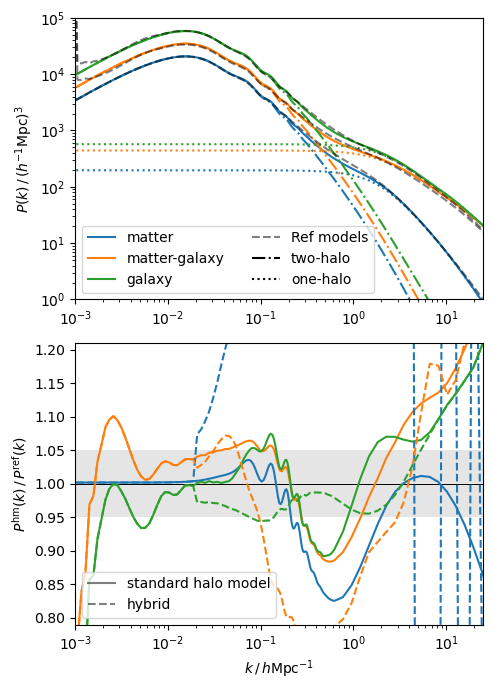

In [15]:
# Parameters
kmin_plt = 1e-3; kmax_plt = 25
Pkmin = 1e0; Pkmax = 1e5
rmin = 0.79; rmax = 1.21

plot_accuracy_lines = False
plot_accuracy_block = True
include_bnl_mm = True

# Line styles
lab_mm = 'matter'; lab_mg = 'matter-galaxy'; lab_gg = 'galaxy'
lab_li = 'linear'; lab_hm = 'standard halo model'; lab_nl = 'with non-linear halo bias'
col_li = 'black'; col_mm = 'C0'; col_mg = 'C1'; col_gg = 'C2'
ls_2h = '-.'; ls_1h = ':'; ls_hm = '-'; ls_hm_res = '-'; ls_nl_res = '--'
# alpha_model = 0.5

# These are the "reference" values that we compare to
Pks_ref = [Pk_HMcode_mm, Pk_dq_mg, Pk_dq_gg]
# Pks_ref = [Pk_dq_mm, Pk_dq_mg, Pk_dq_gg]
cols    = [col_mm, col_mg, col_gg]
labs_model = ['HMcode', 'DarkEmu', 'DarkEmu']

# Halo model without beta_nl
Pks_2h = [Pk_2h_mm, Pk_2h_mg, Pk_2h_gg]
Pks_1h = [Pk_1h_mm, Pk_1h_mg, Pk_1h_gg]
Pks_hm = [Pk_hm_mm, Pk_hm_mg, Pk_hm_gg]

cols = [col_mm, col_mg, col_gg]
labs = [lab_mm, lab_mg, lab_gg]
if include_Bnl:
    Pks_2h_bnl = [Pk_2h_bnl_mm, Pk_2h_bnl_mg, Pk_2h_bnl_gg]
    Pks_hm_bnl = [Pk_hm_bnl_mm, Pk_hm_bnl_mg, Pk_hm_bnl_gg]
    Pks_hybrid_bnl = [Pk_HMcode_mm, Pk_hm_bnl_mg, Pk_hm_bnl_gg]
#     Pks_hybrid_bnl = [Pk_HMcode_mm, Pk_hm_bnl_mg/Pk_hm_bnl_mm*Pk_HMcode_mm, Pk_hm_bnl_gg/Pk_hm_bnl_mm*Pk_HMcode_mm]
    Pks_hybrid_hm = [Pk_HMcode_mm, Pk_hm_mg/Pk_hm_mm*Pk_HMcode_mm, Pk_hm_gg/Pk_hm_mm*Pk_HMcode_mm]
    Pks_hybrid_dq = [Pk_HMcode_mm, Pk_dq_mg/Pk_dq_mm*Pk_HMcode_mm, Pk_dq_gg/Pk_dq_mm*Pk_HMcode_mm]
    Pks_hybrid_bnl_dq = [Pk_HMcode_mm, Pk_hm_bnl_mg/Pk_dq_mm*Pk_HMcode_mm, Pk_hm_bnl_gg/Pk_dq_mm*Pk_HMcode_mm]

Pks_hybrid = Pks_hybrid_bnl.copy()

# Initialise
plt.subplots(2, 1, figsize=(5, 7), dpi=100, sharex=True)

# P(k)
plt.subplot(2, 1, 1)

# Stadard halo model predictions without non-linear halo bias 
for (Pk_2h, Pk_1h, Pk_hm, col, lab) in zip(Pks_2h, Pks_1h, Pks_hm, cols, labs):
    for (Pk, ls, lab) in zip([Pk_2h, Pk_1h, Pk_hm], [ls_2h, ls_1h, ls_hm], [None, None, lab]):
        plt.plot(ks, Pk, ls=ls, color=col, label=lab)

# Reference models
for (Pk, col, lab) in zip(Pks_ref, cols, labs):
    plt.plot(ks, Pk, color='k', ls='--',alpha=0.5)

plt.plot(np.nan, ls='--', color='black',alpha=0.5, label='Ref models')

for ls, lab in zip([ls_2h, ls_1h], ['two-halo', 'one-halo']):
    plt.plot(np.nan, ls=ls, color='black', label=lab)

# Axes
plt.xticks([])
plt.xlim((kmin_plt, kmax_plt))
plt.xscale('log')
plt.ylabel(r'$P(k)\,/\,(h^{-1}\mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.yscale('log')
plt.legend(ncol=2, loc='lower left')


# Residual with HMcode and Dark Emulator
plt.subplot(2, 1, 2)

# Horizontal lines
plt.axhline(1., color='black', lw=.7)
if plot_accuracy_lines:
    for x in [0.9, 0.99, 1.01, 1.1]:
        plt.axhline(x, color='black', ls=':')
if plot_accuracy_block:
    plt.axhspan(0.95, 1.05, alpha=0.1, color='black', lw=0.)
    
# Residual of standard halo model
# plt.plot(ks, Pk_lin_camb/Pk_HMcode_mm, color=col_li, label=lab_li)
for (Pk_hm, Pk_ref, col) in zip(Pks_hm, Pks_ref, cols):
    plt.plot(ks, Pk_hm/Pk_ref, color=col, ls=ls_hm_res)

# Residual of beta_nl halo model
if include_Bnl:
    for (Pk_hm, Pk_ref, col) in zip(Pks_hm_bnl, Pks_ref, cols):
        if (not include_bnl_mm) and (col == col_mm):
            continue 
        else:
            plt.plot(ks, Pk_hm/Pk_ref, color=col, ls=ls_nl_res)
    
# Labels
plt.plot(np.nan, color='black', alpha=0.5, ls=ls_hm_res, label=lab_hm)
if include_Bnl:
    plt.plot(np.nan, color='black', alpha=0.5, ls=ls_nl_res, label='hybrid')
        
# Axes
plt.xlabel(r'$k\,/\,h\mathrm{Mpc}^{-1}$')
plt.xlim((kmin_plt, kmax_plt))
plt.xscale('log')
plt.ylabel(r'$P^\mathrm{hm}(k)\,/\,P^\mathrm{ref}(k)$')
plt.ylim((rmin, rmax))
plt.legend(loc='lower left')

outfile = 'plots/hm_comp.pdf'
# Finalise
plt.tight_layout()
plt.savefig(outfile,bbox_inches='tight')
plt.show()

The top plot shows the power spectra from the standard halo model (solid) and the reference models (dashed). The 1 and 2 halo term contributions to the halo model are shown separately. 
For the bottom plot we show ratios of the halo model predictions with respect to reference power spectra.
The reference values come from HMcode for matter power spectrum and the Dark Emulator for galaxy and galaxy-matter power spectra. We show the result for both the standrad and with non-linear halo bias correction halo models.

In [ ]:
end here

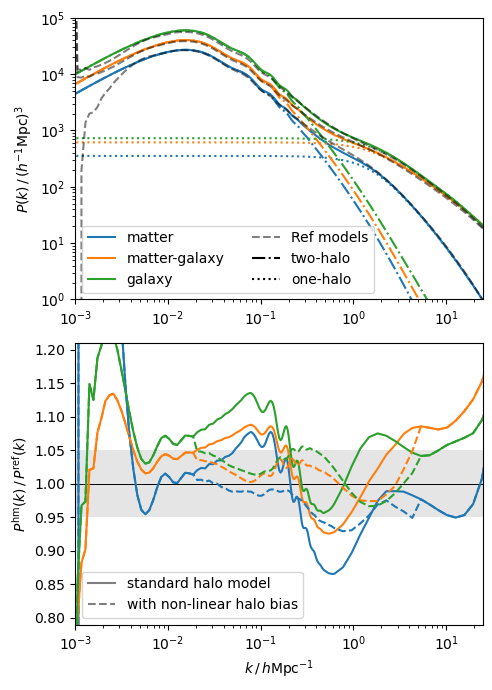

In [27]:
# Initialise
plt.subplots(2, 1, figsize=(5, 7), dpi=100, sharex=True)

# P(k)
plt.subplot(2, 1, 1)

# Stadard halo model predictions without non-linear halo bias 
for (Pk_2h, Pk_1h, Pk_hm, col, lab) in zip(Pks_2h, Pks_1h, Pks_hm, cols, labs):
    for (Pk, ls, lab) in zip([Pk_2h, Pk_1h, Pk_hm], [ls_2h, ls_1h, ls_hm], [None, None, lab]):
        plt.plot(ks, Pk, ls=ls, color=col, label=lab)

# Reference models
for (Pk, col, lab) in zip(Pks_ref, cols, labs):
    plt.plot(ks, Pk, color='k', ls='--',alpha=0.5)

plt.plot(np.nan, ls='--', color='black',alpha=0.5, label='Ref models')

for ls, lab in zip([ls_2h, ls_1h], ['two-halo', 'one-halo']):
    plt.plot(np.nan, ls=ls, color='black', label=lab)

# Axes
plt.xticks([])
plt.xlim((kmin_plt, kmax_plt))
plt.xscale('log')
plt.ylabel(r'$P(k)\,/\,(h^{-1}\mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.yscale('log')
plt.legend(ncol=2, loc='lower left')


# Residual with HMcode and Dark Emulator
plt.subplot(2, 1, 2)

# Horizontal lines
plt.axhline(1., color='black', lw=.7)
if plot_accuracy_lines:
    for x in [0.9, 0.99, 1.01, 1.1]:
        plt.axhline(x, color='black', ls=':')
if plot_accuracy_block:
    plt.axhspan(0.95, 1.05, alpha=0.1, color='black', lw=0.)
    
# Residual of standard halo model
# plt.plot(ks, Pk_lin_camb/Pk_HMcode_mm, color=col_li, label=lab_li)
for (Pk_hm, Pk_ref, col) in zip(Pks_hm, Pks_ref, cols):
    plt.plot(ks, Pk_hm/Pk_ref, color=col, ls=ls_hm_res)

# Residual of beta_nl halo model
if include_Bnl:
    for (Pk_hm, Pk_ref, col) in zip(Pks_hm_bnl, Pks_ref, cols):
        if (not include_bnl_mm) and (col == col_mm):
            continue 
        else:
            plt.plot(ks, Pk_hm/Pk_ref, color=col, ls=ls_nl_res)
    
# Labels
plt.plot(np.nan, color='black', alpha=0.5, ls=ls_hm_res, label=lab_hm)
if include_Bnl:
    plt.plot(np.nan, color='black', alpha=0.5, ls=ls_nl_res, label=lab_nl)
        
# Axes
plt.xlabel(r'$k\,/\,h\mathrm{Mpc}^{-1}$')
plt.xlim((kmin_plt, kmax_plt))
plt.xscale('log')
plt.ylabel(r'$P^\mathrm{hm}(k)\,/\,P^\mathrm{ref}(k)$')
plt.ylim((rmin, rmax))
plt.legend(loc='lower left')

outfile = 'plots/hm_comp.pdf'
# Finalise
plt.tight_layout()
plt.savefig(outfile,bbox_inches='tight')
plt.show()

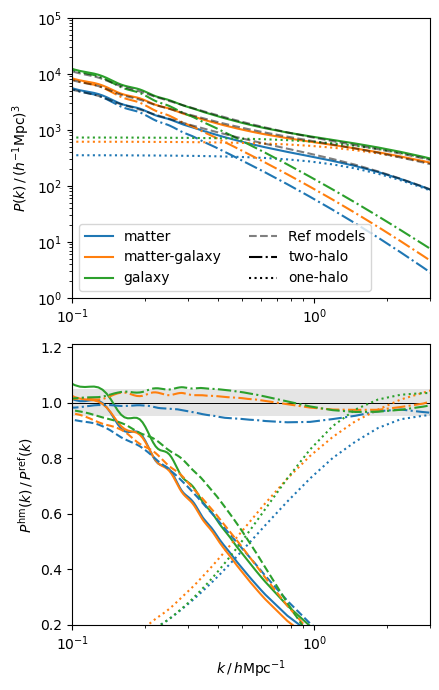

In [28]:
# Initialise
plt.subplots(2, 1, figsize=(4.5, 7), dpi=100, sharex=True)
kmin_plt=0.1
kmax_plt=3.0
# P(k)
plt.subplot(2, 1, 1)

# Stadard halo model predictions without non-linear halo bias 
for (Pk_2h, Pk_1h, Pk_hm, col, lab) in zip(Pks_2h, Pks_1h, Pks_hm, cols, labs):
    for (Pk, ls, lab) in zip([Pk_2h, Pk_1h, Pk_hm], [ls_2h, ls_1h, ls_hm], [None, None, lab]):
        plt.plot(ks, Pk, ls=ls, color=col, label=lab)

# Reference models
for (Pk, col, lab) in zip(Pks_ref, cols, labs):
    plt.plot(ks, Pk, color='k', ls='--',alpha=0.5)

plt.plot(np.nan, ls='--', color='black',alpha=0.5, label='Ref models')

for ls, lab in zip([ls_2h, ls_1h], ['two-halo', 'one-halo']):
    plt.plot(np.nan, ls=ls, color='black', label=lab)

# Axes
plt.xticks([])
plt.xlim((kmin_plt, kmax_plt))
plt.xscale('log')
plt.ylabel(r'$P(k)\,/\,(h^{-1}\mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.yscale('log')
plt.legend(ncol=2, loc='lower left')


# Residual with HMcode and Dark Emulator
plt.subplot(2, 1, 2)

# Horizontal lines
plt.axhline(1., color='black', lw=.7)
if plot_accuracy_lines:
    for x in [0.9, 0.99, 1.01, 1.1]:
        plt.axhline(x, color='black', ls=':')
if plot_accuracy_block:
    plt.axhspan(0.95, 1.05, alpha=0.1, color='black', lw=0.)
    
# Residual of standard halo model
# plt.plot(ks, Pk_lin_camb/Pk_HMcode_mm, color=col_li, label=lab_li)
for (Pk_hm, Pk_ref, col) in zip(Pks_2h, Pks_ref, cols):
    plt.plot(ks, Pk_hm/Pk_ref, color=col, ls=ls_hm_res)

# Residual of beta_nl halo model
if include_Bnl:
    for (Pk_hm, Pk_ref,Pk_1h,Pk_2h, col) in zip(Pks_hm_bnl, Pks_ref, Pks_1h, Pks_2h_bnl, cols):
        if (not include_bnl_mm) and (col == col_mm):
            continue 
        else:
            plt.plot(ks, Pk_hm/Pk_ref, color=col, ls="-.")
            plt.plot(ks, Pk_1h/Pk_ref, color=col, ls=":")
            plt.plot(ks, Pk_2h/Pk_ref, color=col, ls="--")
    
# Labels
plt.plot(np.nan, color='black', alpha=0.5, ls=ls_hm_res, label=lab_hm)
if include_Bnl:
    plt.plot(np.nan, color='black', alpha=0.5, ls=ls_nl_res, label=lab_nl)
        
# Axes
plt.xlabel(r'$k\,/\,h\mathrm{Mpc}^{-1}$')
plt.xlim((kmin_plt, kmax_plt))
plt.xscale('log')
plt.ylabel(r'$P^\mathrm{hm}(k)\,/\,P^\mathrm{ref}(k)$')
plt.ylim((0.2, rmax))
# plt.legend(loc='lower left')

outfile = 'plots/hm_comp.pdf'
# Finalise
plt.tight_layout()
plt.savefig(outfile,bbox_inches='tight')
plt.show()

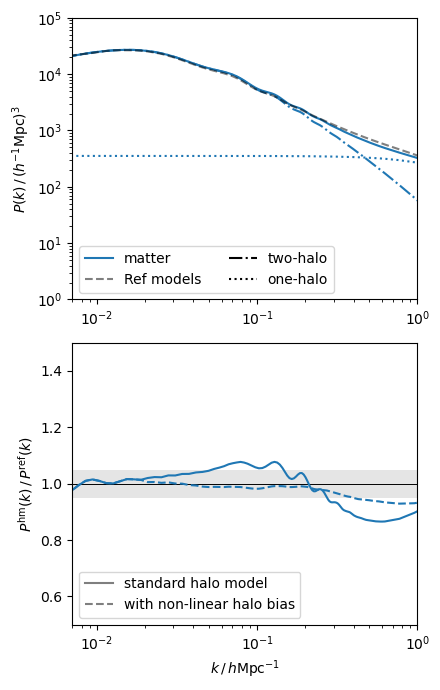

In [29]:
#  To match Mead and Verde
kmin_plt = 7e-3; kmax_plt = 1
Pkmin = 1e0; Pkmax = 1e5
rmin = 0.5; rmax = 1.5

# These are the "reference" values that we compare to
Pks_ref = [Pk_dq_mm]
cols    = [col_mm]
labs_model = ['DarkEmu']

# Halo model without beta_nl
Pks_2h = [Pk_2h_mm]
Pks_1h = [Pk_1h_mm]
Pks_hm = [Pk_hm_mm]
cols = [col_mm]
labs = [lab_mm]
if include_Bnl:
    Pks_hm_bnl = [Pk_hm_bnl_mm]

# Initialise
plt.subplots(2, 1, figsize=(4.5, 7), dpi=100, sharex=True)

# P(k)
plt.subplot(2, 1, 1)

# Stadard halo model predictions without non-linear halo bias 
for (Pk_2h, Pk_1h, Pk_hm, col, lab) in zip(Pks_2h, Pks_1h, Pks_hm, cols, labs):
    for (Pk, ls, lab) in zip([Pk_2h, Pk_1h, Pk_hm], [ls_2h, ls_1h, ls_hm], [None, None, lab]):
        plt.plot(ks, Pk, ls=ls, color=col, label=lab)

# Reference models
for (Pk, col, lab) in zip(Pks_ref, cols, labs):
    plt.plot(ks, Pk, color='k', ls='--',alpha=0.5)

plt.plot(np.nan, ls='--', color='black',alpha=0.5, label='Ref models')

for ls, lab in zip([ls_2h, ls_1h], ['two-halo', 'one-halo']):
    plt.plot(np.nan, ls=ls, color='black', label=lab)

# Axes
plt.xticks([])
plt.xlim((kmin_plt, kmax_plt))
plt.xscale('log')
plt.ylabel(r'$P(k)\,/\,(h^{-1}\mathrm{Mpc})^3$')
plt.ylim((Pkmin, Pkmax))
plt.yscale('log')
plt.legend(ncol=2, loc='lower left')


# Residual with HMcode and Dark Emulator
plt.subplot(2, 1, 2)

# Horizontal lines
plt.axhline(1., color='black', lw=.7)
if plot_accuracy_lines:
    for x in [0.9, 0.99, 1.01, 1.1]:
        plt.axhline(x, color='black', ls=':')
if plot_accuracy_block:
    plt.axhspan(0.95, 1.05, alpha=0.1, color='black', lw=0.)
    
# Residual of standard halo model
# plt.plot(ks, Pk_lin_camb/Pk_HMcode_mm, color=col_li, label=lab_li)
for (Pk_hm, Pk_ref, col) in zip(Pks_hm, Pks_ref, cols):
    plt.plot(ks, Pk_hm/Pk_ref, color=col, ls=ls_hm_res)

# Residual of beta_nl halo model
if include_Bnl:
    for (Pk_hm, Pk_ref, col) in zip(Pks_hm_bnl, Pks_ref, cols):
        if (not include_bnl_mm) and (col == col_mm):
            continue 
        else:
            plt.plot(ks, Pk_hm/Pk_ref, color=col, ls=ls_nl_res)
    
# Labels
plt.plot(np.nan, color='black', alpha=0.5, ls=ls_hm_res, label=lab_hm)
if include_Bnl:
    plt.plot(np.nan, color='black', alpha=0.5, ls=ls_nl_res, label=lab_nl)
        
# Axes
plt.xlabel(r'$k\,/\,h\mathrm{Mpc}^{-1}$')
plt.xlim((kmin_plt, kmax_plt))
plt.xscale('log')
plt.ylabel(r'$P^\mathrm{hm}(k)\,/\,P^\mathrm{ref}(k)$')
plt.ylim((rmin, rmax))
plt.legend(loc='lower left')

outfile = 'plots/hm_comp.pdf'
# Finalise
plt.tight_layout()
plt.savefig(outfile,bbox_inches='tight')
plt.show()